# Задание 9. Поиск максимума среди минимальных значений строк матрицы с вложенным параллелизмом
Алгоритмы для решения данной задачи взяты из [задачи 4](../matrixMiniMax/matrixMiniMax.ipynb). Единственной модификацией является добавление метода `findMiniMaxReductionNested`, который является модификацией подхода с редукцией с добавлением распараллеливания по данным с редукцией для вложенных циклов.

## Описание подходов
Все описанные алгоритмы находятся в модуле [`nestedParallelism`](../../nestedParallelism/nestedParallelism.c).

### Однопоточная версия
Реализация данного подхода содержится в методе ` findMiniMaxSingleThread`. 

```c
static int findMiniMaxSingleThread(Matrix *matrix)
{
    int maxVal = INT_MIN;

    for (int i = 0; i < matrix->nRows; i++)
    {
        int rowMin = GetMatrixElem(matrix, i, 0);
        for (int j = 1; j < matrix->nCols; j++)
        {
            int curr = GetMatrixElem(matrix, i, j);
            if (curr < rowMin)
            {
                rowMin = curr;
            }
        }
        if (rowMin > maxVal)
        {
            maxVal = rowMin;
        }
    }
    return maxVal;
}
```

### Редукция
В данном подходе использована редукция с оператором `max`. 
```c
static int findMiniMaxReduction(Matrix *matrix)
{
    int maxVal = INT_MIN;
#pragma omp parallel for shared(matrix) reduction(max \
                                                  : maxVal)
    for (int i = 0; i < matrix->nRows; i++)
    {
        int rowMin = GetMatrixElem(matrix, i, 0);
        for (int j = 1; j < matrix->nCols; j++)
        {
            int curr = GetMatrixElem(matrix, i, j);
            if (curr < rowMin)
            {
                rowMin = curr;
            }
        }

        if (rowMin > maxVal)
        {
            maxVal = rowMin;
        }
    }

    return maxVal;
}
```

### Редукция с вложенным параллелизмом
В данном подходе использована к предыдущему методу добавлено распраллеливание по вложенному циклу for с редукцией с оператором `min`. 

```c
static int findMiniMaxReductionNested(Matrix *matrix)
{
    int maxVal = INT_MIN;
#pragma omp parallel for shared(matrix) reduction(max \
                                                  : maxVal)
    for (int i = 0; i < matrix->nRows; i++)
    {
        int rowMin = GetMatrixElem(matrix, i, 0);
#pragma omp parallel for shared(matrix) reduction(min \
                                                  : rowMin)
        for (int j = 1; j < matrix->nCols; j++)
        {
            int curr = GetMatrixElem(matrix, i, j);
            if (curr < rowMin)
            {
                rowMin = curr;
            }
        }

        if (rowMin > maxVal)
        {
            maxVal = rowMin;
        }
    }

    return maxVal;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы для квадратных матриц размера 10 * 10, 100 * 100 и 1000 * 1000 элементов.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
dataset["num_elements"] = dataset['n_rows'] * dataset['n_cols']
dataset = dataset.astype({'method': 'category', 'num_elements': 'category'})
print(dataset.head(10))


   num_threads     method  n_rows  n_cols  elapsed_time num_elements
0            1     single      10      10        0.0011          100
1            2  reduction      10      10        0.0520          100
2            2     nested      10      10        0.0191          100
3            3  reduction      10      10        0.0499          100
4            3     nested      10      10        0.0126          100
5            4  reduction      10      10        0.0704          100
6            4     nested      10      10        0.0131          100
7            5  reduction      10      10        0.0392          100
8            5     nested      10      10        0.0141          100
9            6  reduction      10      10        0.0724          100


Рассчитаем среднее время работы каждого из описанных подходов для каждого из имеющихся методов.

In [2]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['num_elements', 'elapsed_time']].groupby('num_elements').agg({'elapsed_time': 'mean'}).sort_values('num_elements')
means_for_nested = dataset[dataset['method'] == 'nested'][['num_elements', 'elapsed_time']].groupby('num_elements').agg({'elapsed_time': 'mean'}).sort_values('num_elements')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['num_elements', 'elapsed_time']].groupby('num_elements').agg({'elapsed_time': 'mean'}).sort_values('num_elements')

In [3]:
num_elements = dataset.num_elements.unique().tolist()

In [4]:
def visualize(ylabel, title, data):
    labels = num_elements
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['single'],
                    width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['nested'],
                    width, label='Редукция с вложенным параллелизмом')
    rects3 = ax.bar(x + width/2, data['reduction'],
                    width, label='Многопоточная с редукцией')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Количество элементов')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров матриц. 

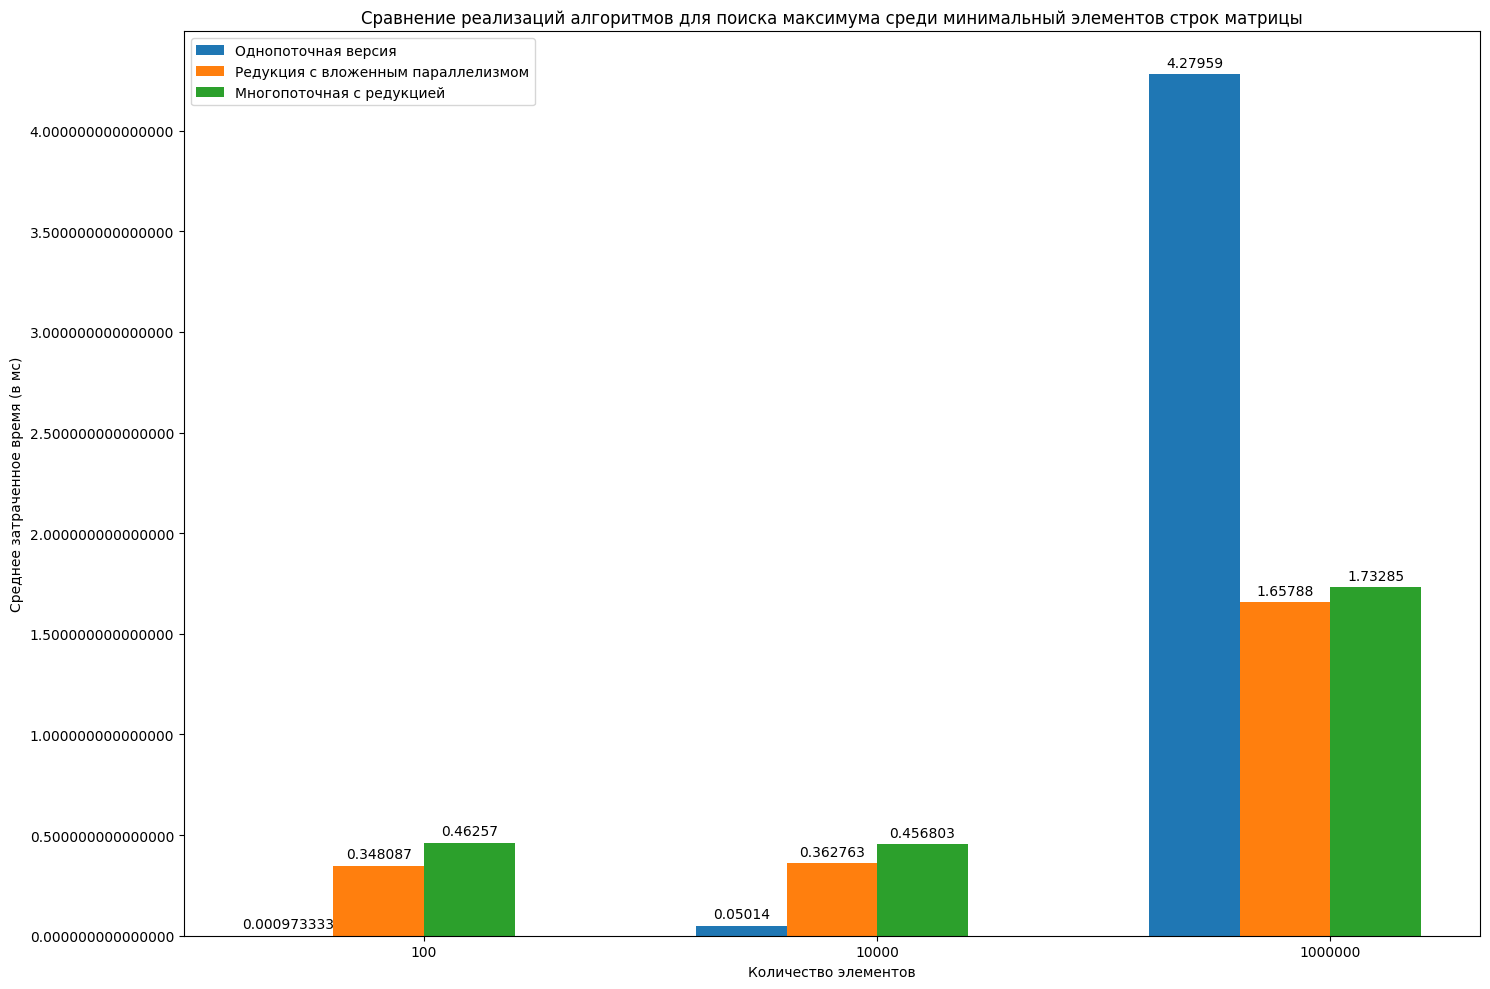

In [5]:
mean_data = dict(zip(dataset['method'].unique(), [
    means_for_single_thread['elapsed_time'],  means_for_reduction['elapsed_time'], means_for_nested['elapsed_time']]))
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для поиска максимума среди минимальный элементов строк матрицы', mean_data)


Легко заметить, что во всех трех случаях версия с вложенным параллелизмом работает быстрее обычной редукции. Рассмотрим подробнее получаемое в зависимости от количества потоков ускорение.

In [6]:
means_for_single_thread = dataset[dataset['method'] == 'single'].groupby(
    'num_elements').agg({'elapsed_time': 'mean'}).reset_index()

means_for_multhread = dataset[dataset['num_threads'] >= 2].groupby(
    ['num_threads', 'num_elements', 'method']).agg({'elapsed_time': 'mean'})
means_for_multhread = means_for_multhread[means_for_multhread['elapsed_time'].notnull(
)].reset_index()


smtet = means_for_multhread[means_for_multhread['num_elements']
                            == num_elements[0]]['elapsed_time']
sstet = means_for_single_thread[means_for_single_thread['num_elements']
                                == num_elements[0]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_elements']
                        == num_elements[0], 'boost'] = sstet.loc[0]/ smtet 

mmtet = means_for_multhread[means_for_multhread['num_elements']
                            == num_elements[1]]['elapsed_time']
mstet = means_for_single_thread[means_for_single_thread['num_elements']
                                == num_elements[1]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_elements']
                        == num_elements[1], 'boost'] = mstet.loc[1] / mmtet 

lmtet = means_for_multhread[means_for_multhread['num_elements']
                            == num_elements[2]]['elapsed_time']
lstet = means_for_single_thread[means_for_single_thread['num_elements']
                                == num_elements[2]]['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_elements']
                        == num_elements[2], 'boost'] = lstet.loc[2] / lmtet 

In [7]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_nested = plt.plot(
        x, data.loc[filters['nested'], 'boost'], label='Редукция с вложенным параллелизмом')
    bfsa_reduction = plt.plot(
        x, data.loc[filters['reduction'], 'boost'], label='Редукция')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()
        

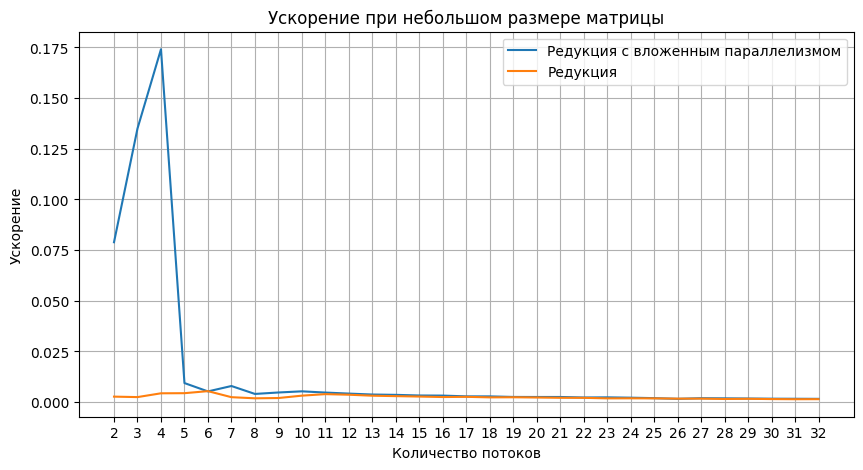

In [8]:
filters_for_small_num_elements = {
    'nested': (means_for_multhread['method'] == 'nested') & (means_for_multhread['num_elements'] == num_elements[0]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_elements'] == num_elements[0]),
}
visualize_boost(means_for_multhread, filters_for_small_num_elements,
                'Ускорение при небольшом размере матрицы')


Как и ожидалось, при небольших размерах матрицы оба алгоритма оказываются менее эффективными, чем однопоточная версия

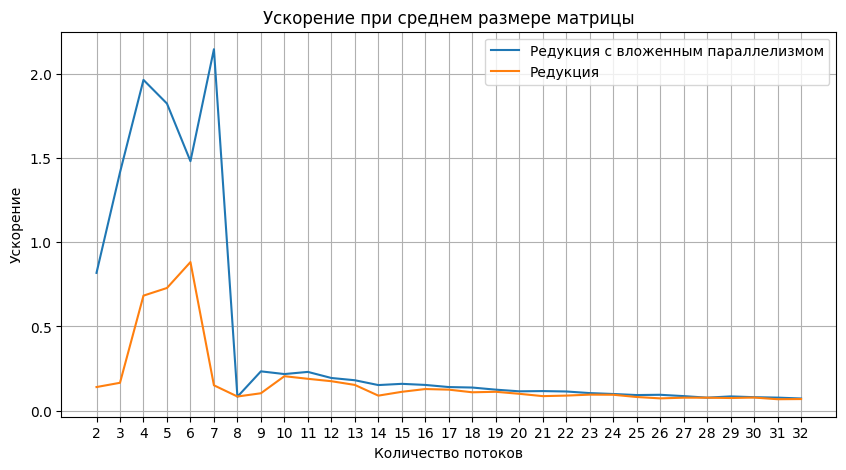

In [9]:
filters_for_medium_arrays = {
    'nested': (means_for_multhread['method'] == 'nested') & (means_for_multhread['num_elements'] == num_elements[1]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_elements'] == num_elements[1])
}
visualize_boost(means_for_multhread, filters_for_medium_arrays,
                'Ускорение при среднем размере матрицы')


Для матриц среднего размера алгоритм с вложенным параллелизмом оказался эффективнее, ускорив программу в 2 раза при использовании 7 потоков.

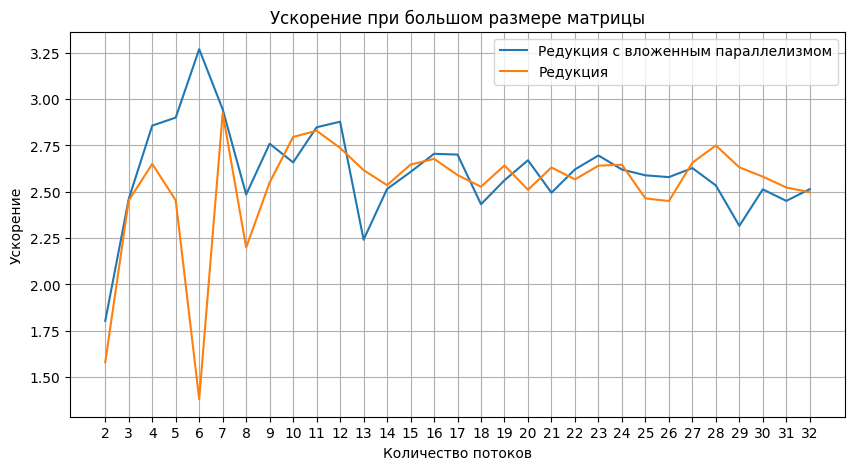

In [10]:
filters_for_large_arrays = {
    'nested': (means_for_multhread['method'] == 'nested') & (means_for_multhread['num_elements'] == num_elements[2]),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['num_elements'] == num_elements[2]),
}
visualize_boost(means_for_multhread, filters_for_large_arrays,
                'Ускорение при большом размере матрицы')


Для матриц большого размера оба алгоритма показали похожее ускорениев в среднем в 2.5 раза. Наиболее эффективной оказалась редукция с вложенным параллелизмом, ускорившая программу более чем в 3 раза при использовании 6 потоков. 